# Импорт библиотек

In [1]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display

# Загрузка данных

In [2]:
if not os.path.exists('./horse2zebra'):
  import gdown
  url = 'https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg'
  gdown.download(url, './horse2zebra.zip', quiet=False)
  !unzip ./horse2zebra.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg
To: /content/horse2zebra.zip
100%|██████████| 117M/117M [00:00<00:00, 169MB/s]


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import shutil, sys 
shutil.move("/content/horse2zebra/train/A", "/content/horses_train/A")
shutil.move("/content/horse2zebra/train/B", "/content/zebra_train/B")
shutil.move("/content/horse2zebra/test/A", "/content/horses_test/A")
shutil.move("/content/horse2zebra/test/B", "/content/zebra_test/B")

'/content/zebra_test/B'

torch.Size([5, 3, 256, 256])


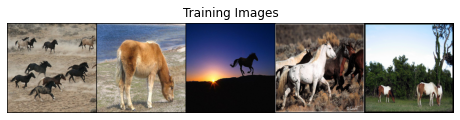

In [5]:
bs = 5
workers = 2
image_size = (256,256)
dataroot = 'horses_train/'
dataset_horses_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_train_horses = torch.utils.data.DataLoader(dataset_horses_train, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_train_horses))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

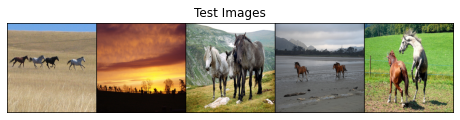

In [6]:
dataroot = 'horses_test/'
dataset_horses_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_test_horses = torch.utils.data.DataLoader(dataset_horses_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_test_horses))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

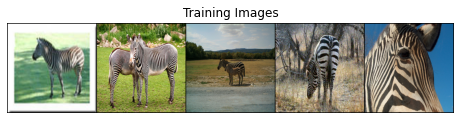

In [7]:
dataroot = 'zebra_train'
dataset_zebra_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_train = torch.utils.data.DataLoader(dataset_zebra_train, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

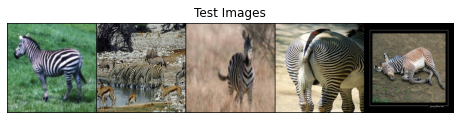

In [8]:
dataroot = 'zebra_test'
dataset_zebra_test = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_test = torch.utils.data.DataLoader(dataset_zebra_test, batch_size=bs,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_test))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
def plot_images_test(dataloader_test_horses, dataloader_zebra_test): 
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()


    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real horses")
    plt.show()

          
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake zebras")
    plt.show()


    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real zebras")
    plt.show()


    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake horses")
    plt.show()

In [10]:
def plot_all_images(image_number, dataloader_test_horses, dataloader_zebra_test): 
    # Генерация фэйковых зебр
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake zebras")
    plt.show()

    # Генерация фэйковых лошадей
    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real zebras")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake horses")
    plt.show()

    # Идентификация 
    identity_a_test=G_B2A(batch_a_test.cuda() ).cpu().detach()
    identity_b_test=G_A2B(batch_b_test.cuda() ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((identity_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Identity zebras")
    plt.show()

    #Восстановленные изображения
    recover_a_test=G_B2A(fake_b_test.cuda()  ).cpu().detach()
    recover_b_test=G_A2B(fake_a_test.cuda()  ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered horses")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered zebras")
    plt.show()

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, "/content/gdrive/My Drive/model_proj3/"+name+"_G_A2B.pt")
  torch.save(G_B2A, "/content/gdrive/My Drive/model_proj3/"+name+"_G_B2A.pt")
  torch.save(D_A, "/content/gdrive/My Drive/model_proj3/"+name+"_D_A.pt")
  torch.save(D_B, "/content/gdrive/My Drive/model_proj3/"+name+"_D_B.pt")

def load_models( name):

  G_A2B=torch.load("/content/gdrive/My Drive/model_proj3/"+name+"_G_A2B.pt")
  G_B2A=torch.load("/content/gdrive/My Drive/model_proj3/"+name+"_G_B2A.pt")
  D_A=torch.load("/content/gdrive/My Drive/model_proj3/"+name+"_D_A.pt")
  D_B=torch.load("/content/gdrive/My Drive/model_proj3/"+name+"_D_B.pt")
  return G_A2B, G_B2A, D_A, D_B

## Генератор

1. Одна из целей генератора - заставить дискриминатор поверить в реальность 
поддельных изображений. Чтобы генератор отлично справлялся с обманом дискриминатора, дискриминатор должен выводить все единицы для сгенерированного изображения. В этом случае генератор получит нулевые потери:

$$min_GLOSS(G)=\frac{1}{2}E(D(G(real))-1)^2.$$

2. Мы накладываем ограничения на генератор. Мы хотим, чтобы генератор мог сначала отображать домен одного класса в домен другого класса, а затем обратно в домен первого класса без каких-либо изменений изображения. Это ограничение накладывается с помощью функции потерь L1 на пиксельном уровне между реальным и восстановленным изображением:

$$L_1=\sum|image_{real}-image_{restored}|.$$

3. Потеря идентичности: если входное изображение уже выглядит как целевой домен, генератор не должен отображать его в другое изображение (например, лошадь не должна реконструироваться в лошадь):

$$L_1=\sum|image_{real}-image_{restored}|.$$

### Архитектура генератора

Генератор состоит из трех основных компонентов: фазы кодирования, трансформации и декодирования.

**Кодировка**:
На этапе кодирования элементы изображения преобразуются в представление скрытого пространства через несколько слоев свертки.

**Трансформация**:
Фаза трансформации состоит из шести или девяти блоков resnet сети и используется для сборки соответствующих скрытых фичей, получанных на этапе кодирования. 

**Декодирование**:
Фаза декодирования противоположна фазе кодирования и восстанваливает изображение из скрытого представления с помощью транспонированных сверток.


<img src='https://miro.medium.com/max/1400/1*mfo0wSc63i2cO1xmBV_tcA.png'>

In [13]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

## Дискриминатор

Цель дискриминатора состоит в том, чтобы классифицировать реальное изображение как реальное, а поддельное как поддельное, для оптимизации используется следующая функция наименьших квадратов:

$$min_D(D) =\frac{1}{2}E((D(image_{real})-1)^2+\frac{1}{2}E((D(G(image_{fake}))^2) $$


### Архитектура дискриминатора


<img src='https://miro.medium.com/max/1400/1*xzWtHA3rRl11sZdluRmxwA.png'>

In [14]:
nc=3
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Размер входного изображения: (nc) x 128 x 128
            nn.Conv2d(nc,64,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,64*2,4,2,1, bias=False),
            nn.InstanceNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*2, 64 * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*4,64*8,4,1,1),
            nn.InstanceNorm2d(64*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*8,1,4,1,1)
        )

    def forward(self, input):
        return self.main(input)

## Loss функция

In [15]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

# Обучение модели

In [16]:
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_Im = torch.nn.L1Loss() 

# Параметры оптимизатора
lr = 0.0002
beta1 = 0.5

In [18]:
def training(G_A2B, G_B2A, D_A, D_B, num_epochs,name):

  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  print("Starting Training Loop...")
  for epoch in range(num_epochs):

    # Для каждого батча
    for  i,(data_horse, data_zebra) in enumerate(zip(dataloader_train_horses, dataloader_zebra_train),0):
    
        # Инпут модели
        a_real = data_horse[0].to(device)
        b_real = data_zebra[0].to(device)
      
        tensor_ones=torch.ones([a_real.shape[0],1,14,14]).cuda()
        tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).cuda()

        # Сгенерированнве изображения
        b_fake = G_A2B(a_real)
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)


        # Дискриминатор A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and iters % 3 == 0):
          rand_int = random.randint(5, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-5:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())
        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Дискриминатор B
        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0)  and iters % 3 == 0):
          rand_int = random.randint(5, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-5:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Генератор
        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()

        ## Пытаемся обмануть дискриминатор
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        ## Огранисение генератора
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        ## Потеря идентичности
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # Общий Loss генератора
        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        # Backward propagation
        Loss_G.backward()
        
        
        # Оптимизация
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == bs*5 and b_fake.shape[0]==bs):
          rand_int = random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del data_zebra, data_horse, a_real, b_real, a_fake, b_fake


        if iters % 50 == 0:
      
          print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    #save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
      plot_images_test(dataloader_test_horses, dataloader_zebra_test)
  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

Starting Training Loop...
[1/3]	FDL_A2B: 0.3022	FDL_B2A: 0.3336	CL_A: 0.7288	CL_B: 0.8058	ID_B2A: 1.3176	ID_A2B: 1.3754	Loss_D_A: 0.5015	Loss_D_A: 0.5238
[1/3]	FDL_A2B: 0.2205	FDL_B2A: 0.3518	CL_A: 0.6591	CL_B: 0.8010	ID_B2A: 1.0481	ID_A2B: 1.3843	Loss_D_A: 0.6272	Loss_D_A: 0.5068
[1/3]	FDL_A2B: 0.5239	FDL_B2A: 0.5260	CL_A: 0.6335	CL_B: 0.6842	ID_B2A: 1.1550	ID_A2B: 1.2195	Loss_D_A: 0.8253	Loss_D_A: 0.4328
[1/3]	FDL_A2B: 0.4390	FDL_B2A: 0.3098	CL_A: 0.5445	CL_B: 0.7361	ID_B2A: 1.0026	ID_A2B: 1.3377	Loss_D_A: 0.4774	Loss_D_A: 0.4551


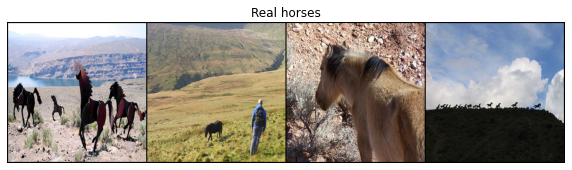

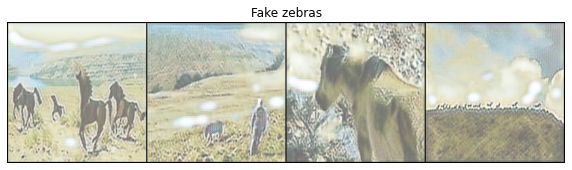

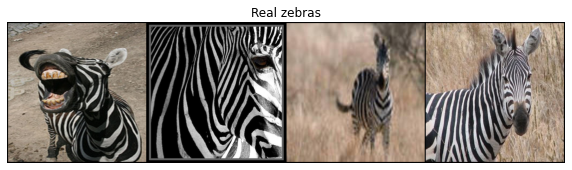

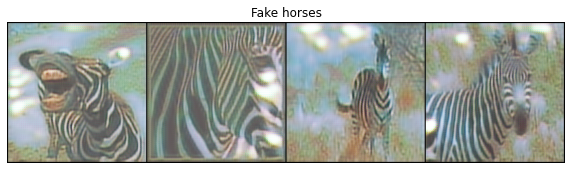

[2/3]	FDL_A2B: 0.5359	FDL_B2A: 0.3905	CL_A: 0.6583	CL_B: 0.6945	ID_B2A: 1.2382	ID_A2B: 1.2703	Loss_D_A: 0.4724	Loss_D_A: 0.3791


In [ ]:
name="my_model"

epochs=3
netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

losses = training( netG_A2B, netG_B2A, netD_A, netD_B,epochs,name)

<img src ='https://camo.githubusercontent.com/16fa02525bf502bec1aac77a3eb5b96928b0f25d73f7d9dedcc041ba28c38751/68747470733a2f2f6a756e79616e7a2e6769746875622e696f2f4379636c6547414e2f696d616765732f7465617365725f686967685f7265732e6a7067'>